In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from typing import Dict, Any
from collections import Counter

import numpy as np
import pandas as pd
import sklearn as sk
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 250
import dvu  # for visualization

import imodels

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')

from experiments.compare_models import get_dataset
from experiments.models.stablelinear import StableLinearClassifier
from experiments.models.stableskope import StableSkopeClassifier
from experiments.notebooks import viz

def get_comparison_result(path: str, estimator_name: str, test=False) -> Dict[str, Any]:
    if test:
        result_file = path + 'test/' + f'{estimator_name}_test_comparisons.pkl'
    else:
        result_file = path + 'val/' + f'{estimator_name}_comparisons.pkl'
    return pkl.load(open(result_file, 'rb'))    
    
MODEL_COMPARISON_PATH = 'experiments/comparison_data/'

datasets = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

# dataset stats

In [2]:
metadata = []
columns = ['name', 'samples', 'features', 'class 0 ct', 'class 1 ct', 'majority class %']
for dataset_name, data_id in datasets:
    dataset = fetch_openml(data_id=data_id, as_frame=False)
    shape = dataset.data.shape
    class_counts = np.unique(dataset.target, return_counts=True)[1]
    metadata.append([dataset_name, shape[0], shape[1], class_counts[0], class_counts[1], np.max(class_counts) / np.sum(class_counts)])
pd.DataFrame(metadata, columns=columns).set_index('name') 

,samples,features,class 0 ct,class 1 ct,majority class %
name,,,,,
breast-cancer,286,9,201,85,0.702797
breast-w,699,9,458,241,0.655222
credit-g,1000,20,300,700,0.700000
haberman,306,3,225,81,0.735294
heart,270,13,150,120,0.555556
labor,57,16,20,37,0.649123
vote,435,16,267,168,0.613793


In [3]:
BEST_ESTIMATORS = [
    [('random_forest', RandomForestClassifier(n_estimators=n, max_depth=2)) for n in np.arange(1, 8)],
    [('gradient_boosting', GradientBoostingClassifier(n_estimators=n, max_depth=1)) for n in np.linspace(1, 20, 10, dtype=int)],
    [('skope_rules', imodels.SkopeRulesClassifier(n_estimators=n, max_depth=1)) for n in np.linspace(2, 200, 10, dtype=int)],
    [('rulefit', imodels.RuleFitClassifier(max_rules=n, tree_size=2)) for n in np.linspace(2, 100, 10, dtype=int)],
    [('fplasso', imodels.FPLassoClassifier(max_rules=n, maxcardinality=1)) for n in np.linspace(2, 100, 10, dtype=int)],
    [('fpskope', imodels.FPSkopeClassifier(maxcardinality=n, max_depth_duplication=3)) for n in np.arange(1, 5)],
    [('brl', imodels.BayesianRuleListClassifier(listlengthprior=n, maxcardinality=2)) for n in np.linspace(1, 16, 8)],
    [('grl', imodels.GreedyRuleListClassifier(max_depth=n)) for n in np.arange(1, 6)],
    [('oner', imodels.OneRClassifier(max_depth=n)) for n in np.arange(1, 6)],
    [('brs', imodels.BoostedRulesClassifier(n_estimators=n)) for n in np.linspace(1, 32, 10, dtype=int)]
]

In [4]:
ds = [13, 15, 31, 43, 1574, 4, 56]
acc_data = {d:[] for d in ds}
prec_data = {d:[] for d in ds}
rec_data = {d:[] for d in ds}
for d in ds:
    all_rules = []
    x, y = get_dataset(d)
    xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, random_state=0)
    for m in [
        imodels.SkopeRulesClassifier(n_estimators=50, max_depth=1),
        imodels.RuleFitClassifier(max_rules=20, tree_size=4),
        imodels.FPLassoClassifier(max_rules=20, maxcardinality=1),
        imodels.BoostedRulesClassifier(n_estimators=10),
        imodels.FPSkopeClassifier(max_depth_duplication=1)
    ]:
        m.fit(xtrain, ytrain)
        all_rules += m.rules_
        acc_data[d].append(accuracy_score(ytest, m.predict(xtest)))
        prec_data[d].append(precision_score(ytest, m.predict(xtest)))
        rec_data[d].append(recall_score(ytest, m.predict(xtest)))
    
    for i in range(len(all_rules)):
        for key in all_rules[i].agg_dict:
            all_rules[i].agg_dict[key] = round(float(all_rules[i].agg_dict[key]), 3)
    repeated_rules_counter = {k:v for k, v in Counter(all_rules).items() if v > 1}
    repeated_rules = list(map(str, repeated_rules_counter.keys()))
    
    for m in [
        StableLinearClassifier(start_rules=repeated_rules),
        StableLinearClassifier(start_rules=repeated_rules, penalty='l2'),
        StableSkopeClassifier(start_rules=repeated_rules)
    ]:
        m.fit(xtrain, ytrain)
        acc_data[d].append(accuracy_score(ytest, m.predict(xtest)))
        prec_data[d].append(precision_score(ytest, m.predict(xtest)))
        rec_data[d].append(recall_score(ytest, m.predict(xtest)))

/Users/keyan/anaconda3/envs/imodels-3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/keyan/anaconda3/envs/imodels-3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/keyan/anaconda3/envs/imodels-3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
ind = ['skp', 'rf', 'fpl', 'brs', 'fps', 'ensemble-lasso', 'ensemble-ridge', 'ensemble-skope']
res_acc = pd.DataFrame(acc_data, index=ind)
res_prec = pd.DataFrame(prec_data, index=ind)
res_rec = pd.DataFrame(rec_data, index=ind)
res_acc.style.background_gradient()

,13,15,31,43,1574,4,56
skp,0.750000,0.937143,0.644000,0.636364,0.838235,0.600000,0.963303
rf,0.666667,0.954286,0.708000,0.545455,0.779412,0.933333,0.954128
fpl,0.680556,0.971429,0.716000,0.545455,0.794118,1.000000,0.954128
brs,0.736111,0.948571,0.472000,0.480519,0.661765,0.933333,0.954128
fps,0.625000,0.840000,0.644000,0.623377,0.661765,0.733333,0.862385
ensemble-lasso,0.694444,0.965714,0.744000,0.545455,0.808824,0.866667,0.963303
ensemble-ridge,0.694444,0.971429,0.740000,0.402597,0.823529,0.866667,0.954128
ensemble-skope,0.625000,0.937143,0.712000,0.532468,0.838235,0.800000,0.871560


In [6]:
res_prec.style.background_gradient()

,13,15,31,43,1574,4,56
skp,0.680000,0.954955,0.871795,0.650000,0.793103,0.636364,0.934783
rf,1.000000,0.972727,0.815951,0.582090,0.842105,1.000000,0.933333
fpl,1.000000,0.981982,0.830189,0.577465,0.818182,1.000000,0.933333
brs,0.666667,0.963964,0.626437,0.750000,0.555556,0.900000,0.933333
fps,0.000000,0.977273,0.871795,0.649123,0.575758,0.692308,0.822222
ensemble-lasso,1.000000,0.973214,0.837349,0.577465,0.826087,0.888889,0.954545
ensemble-ridge,1.000000,0.981982,0.836364,0.000000,0.944444,0.888889,0.953488
ensemble-skope,0.000000,0.963303,0.833333,0.573529,0.793103,0.875000,0.788462


In [7]:
res_rec.style.background_gradient()

,13,15,31,43,1574,4,56
skp,0.629630,0.946429,0.579545,0.847826,0.821429,0.777778,0.977273
rf,0.111111,0.955357,0.755682,0.847826,0.571429,0.888889,0.954545
fpl,0.148148,0.973214,0.750000,0.891304,0.642857,1.000000,0.954545
brs,0.592593,0.955357,0.619318,0.195652,0.892857,1.000000,0.954545
fps,0.000000,0.767857,0.579545,0.804348,0.678571,1.000000,0.840909
ensemble-lasso,0.185185,0.973214,0.789773,0.891304,0.678571,0.888889,0.954545
ensemble-ridge,0.185185,0.973214,0.784091,0.000000,0.607143,0.888889,0.931818
ensemble-skope,0.000000,0.937500,0.738636,0.847826,0.821429,0.777778,0.931818


In [8]:
np.random.seed(0)
x, y = get_dataset(13)
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, random_state=0)
m = imodels.FPLassoClassifier(max_rules=20, maxcardinality=1)
m.fit(xtrain, ytrain)
print(accuracy_score(ytest, m.predict(xtest)))
print(m.rules_)

0.6805555555555556
[feature_2 <= 2.5]


In [9]:
from imodels.util.convert import tree_to_rules

np.random.seed(0)
x, y = get_dataset(13)
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(x, y, random_state=0)
m = imodels.BoostedRulesClassifier(n_estimators=10)
m.fit(xtrain, ytrain)
#m.predict_proba(xtest)

BoostedRulesClassifier()

# complexity vs. ROC Area plot for all models

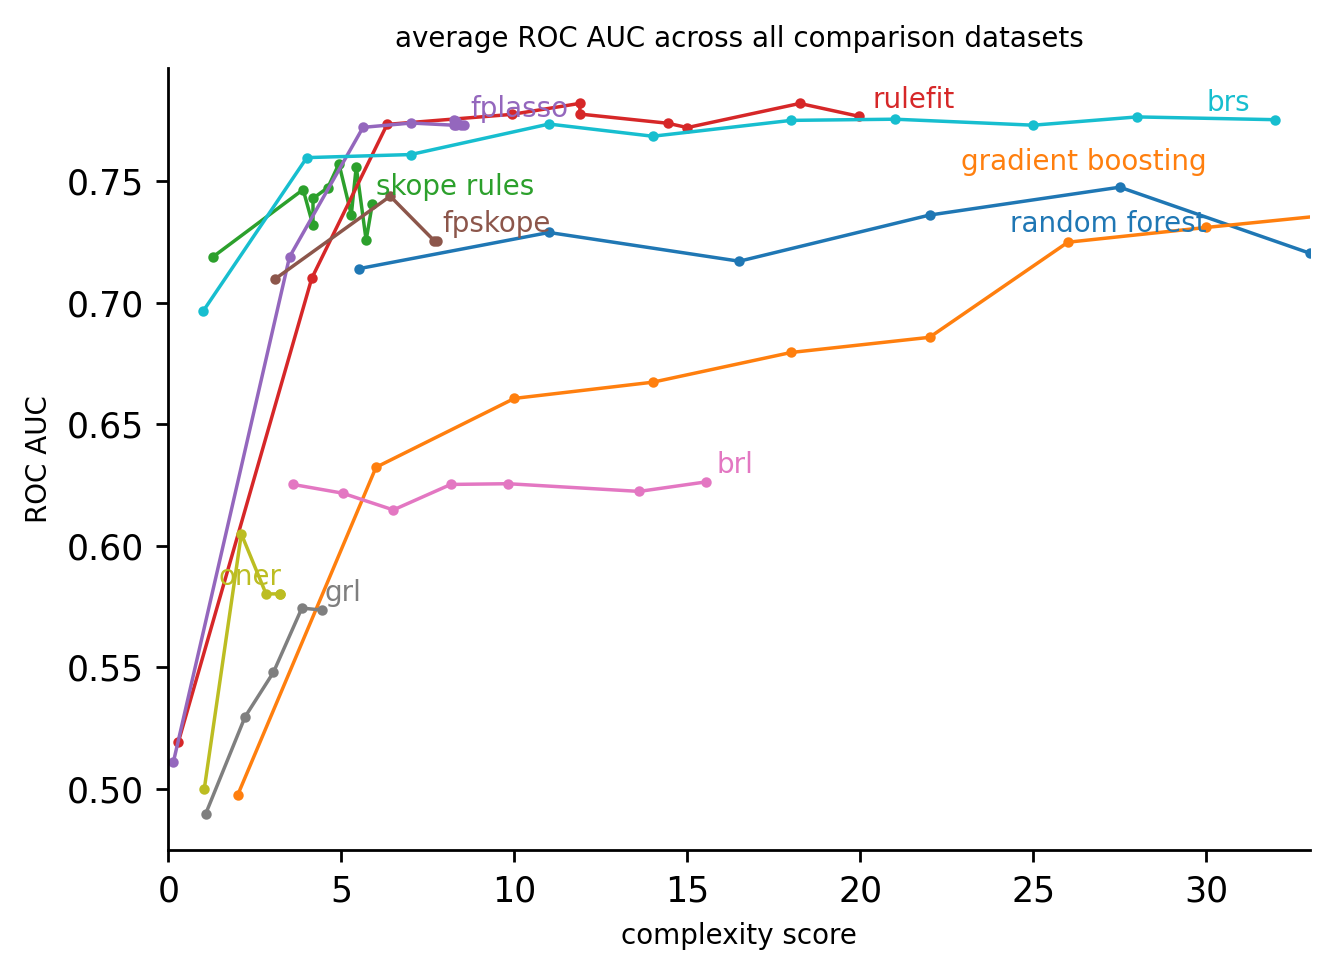

In [10]:
test_models = [
    'random_forest', 
    'gradient_boosting', 
    'skope_rules', 
    'rulefit', 
    'fplasso', 
    'fpskope',
    'brl',
    'grl',
    'oner',
    'brs']
test_results = [get_comparison_result(MODEL_COMPARISON_PATH, mname, test=True)
                for mname in test_models]
viz.viz_comparison_test_average(test_results)
plt.show()

**check individual datasets**

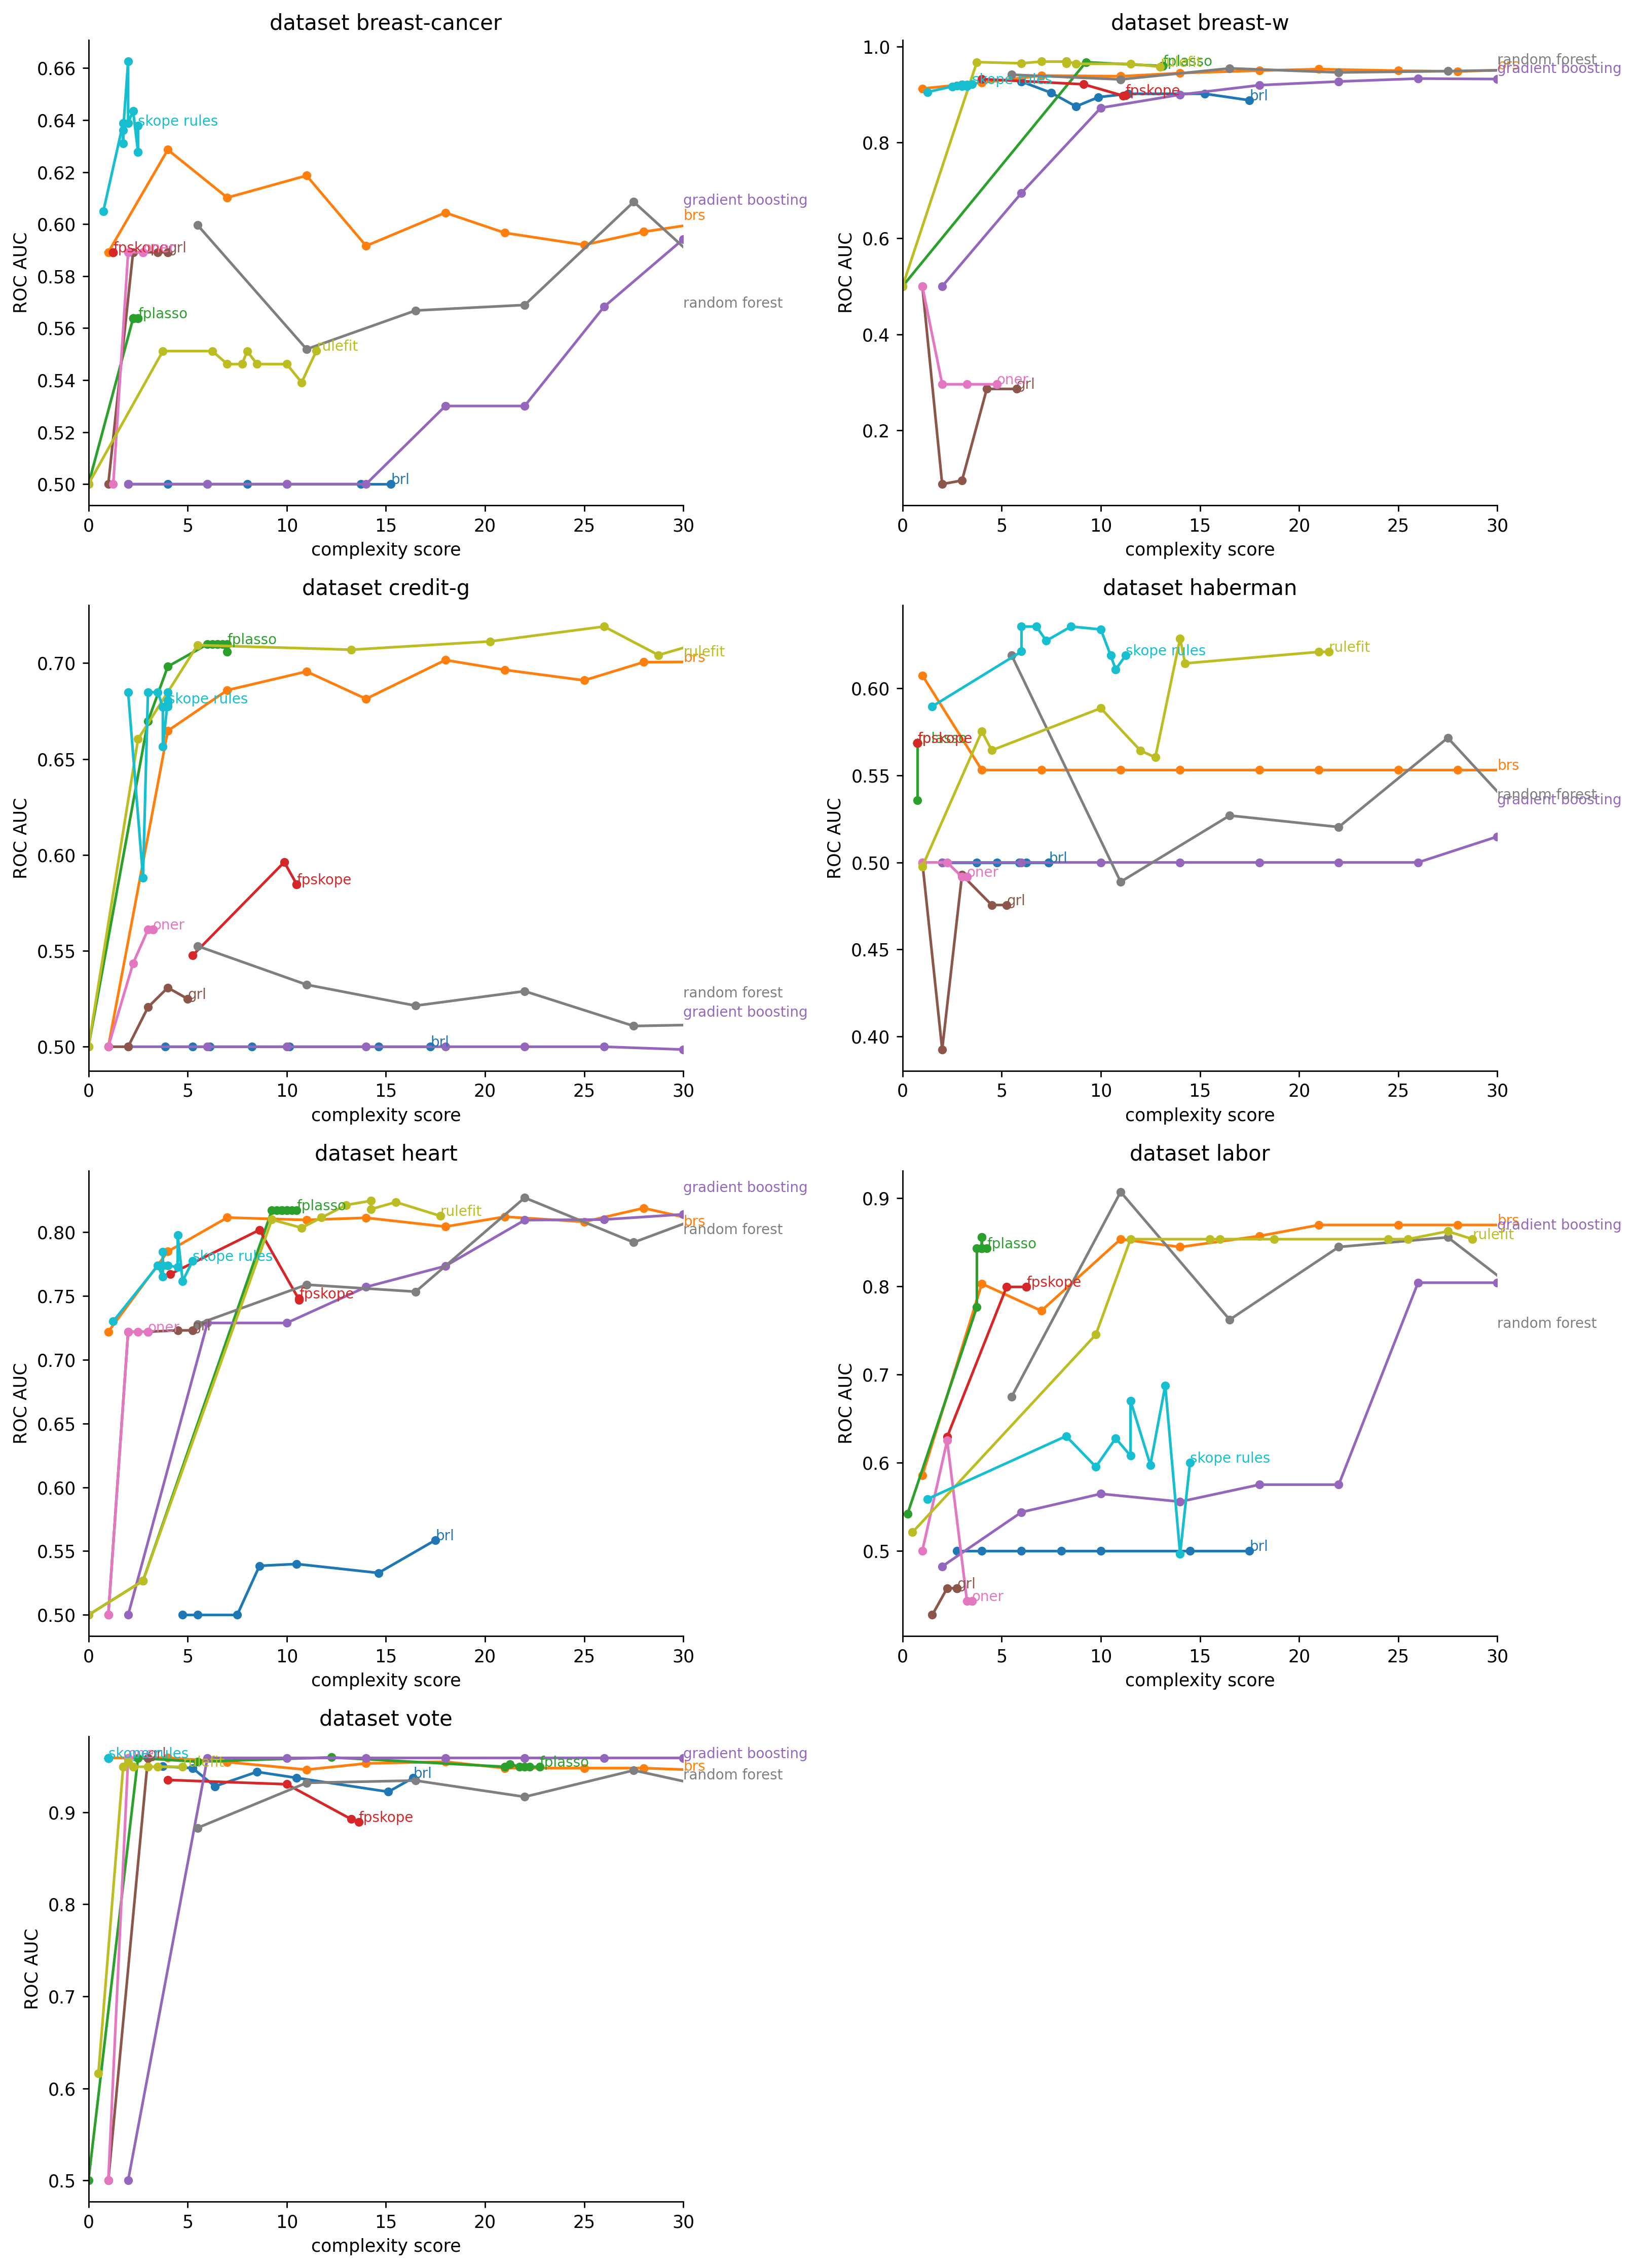

In [11]:
viz.viz_comparison_datasets(test_results, cols=2, figsize=(13, 18), test=True)
plt.show()

# check each model

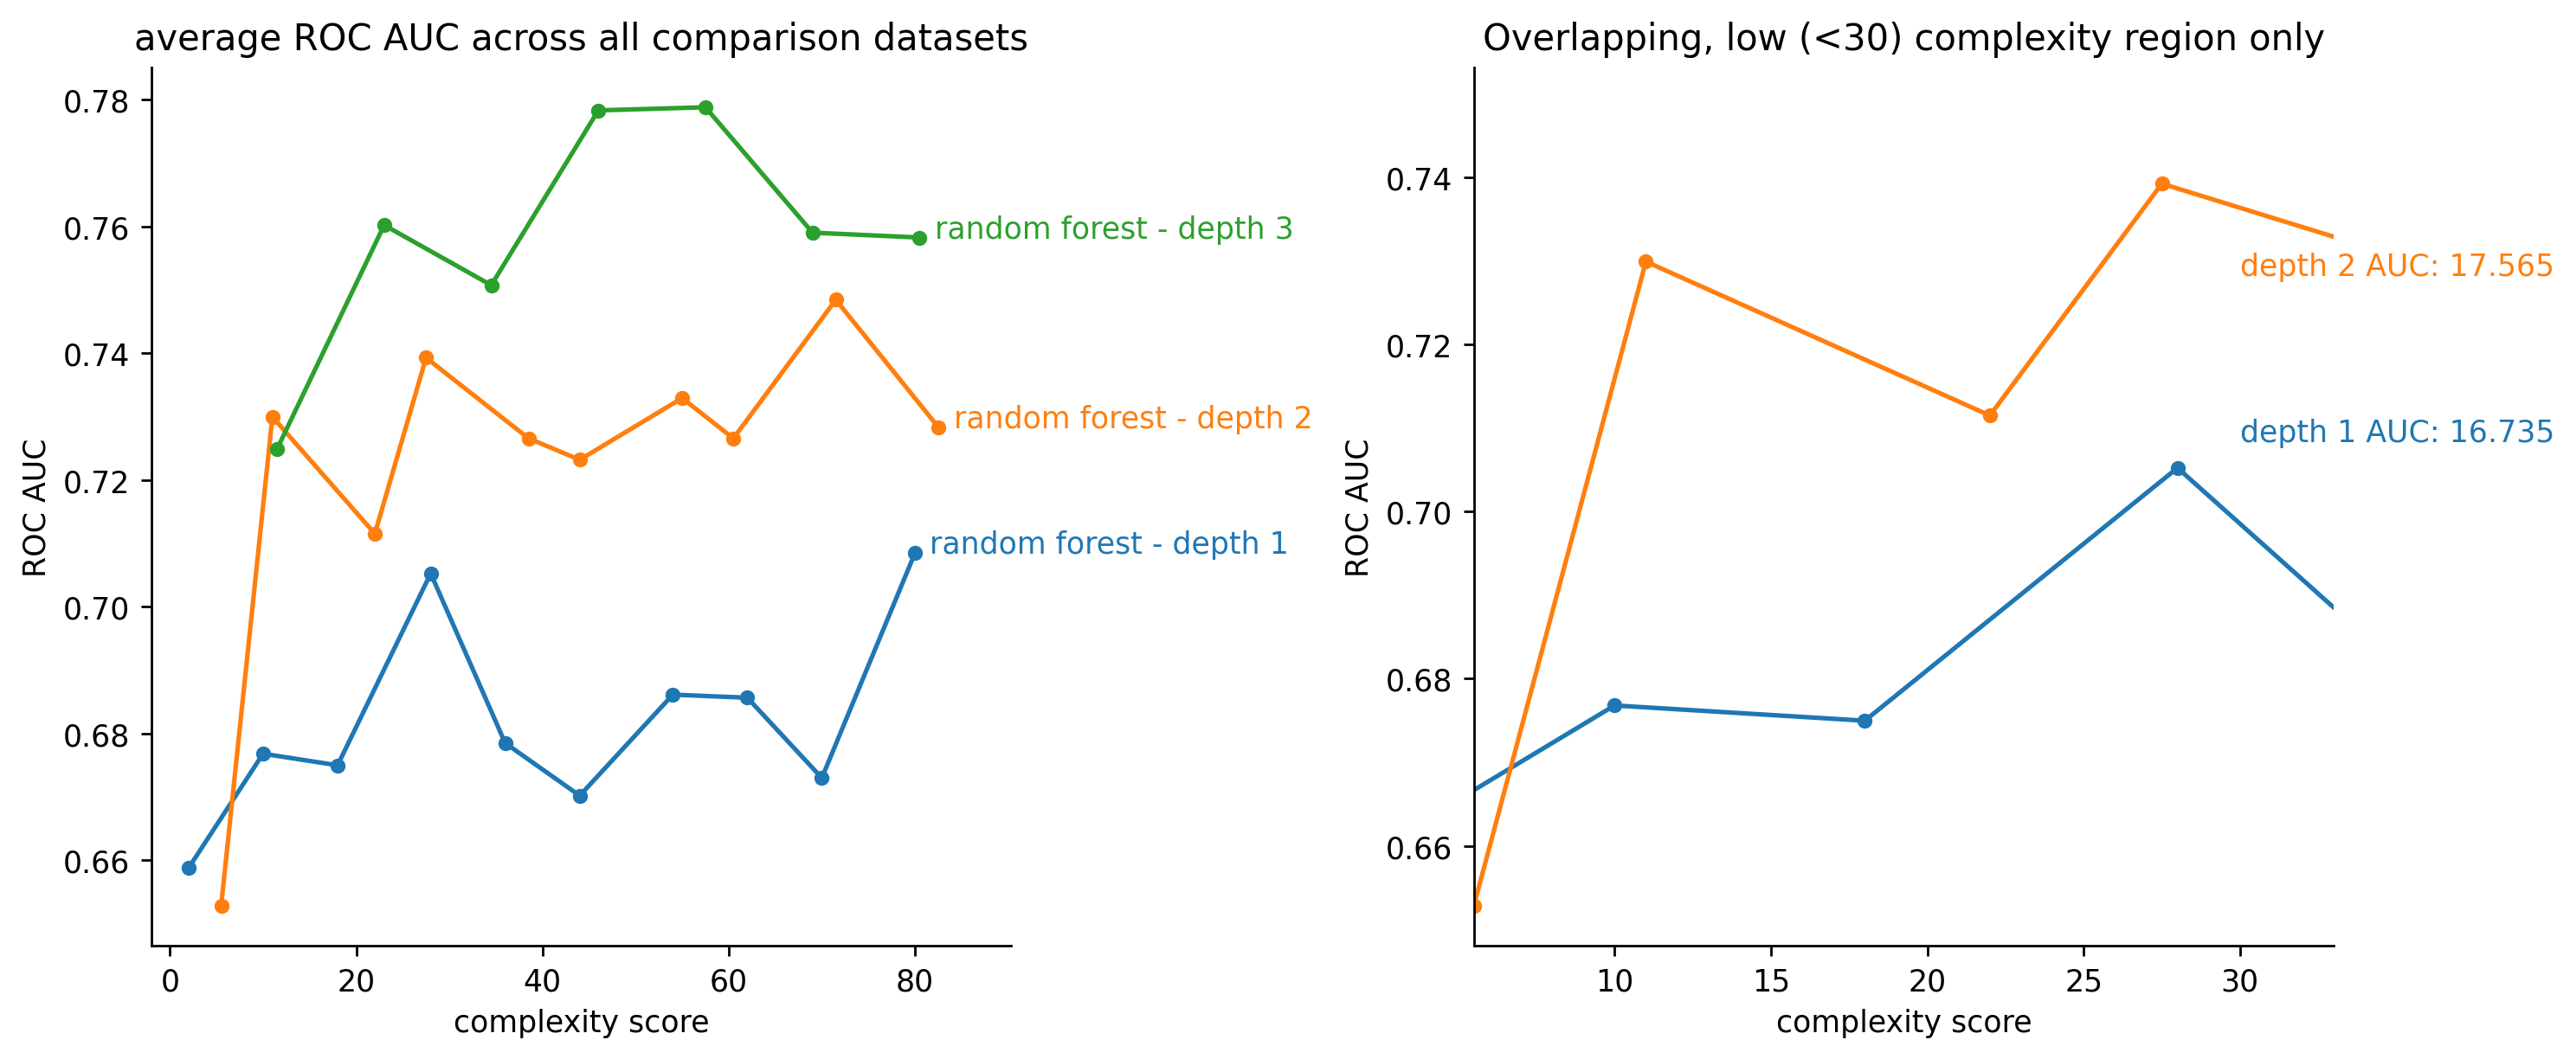

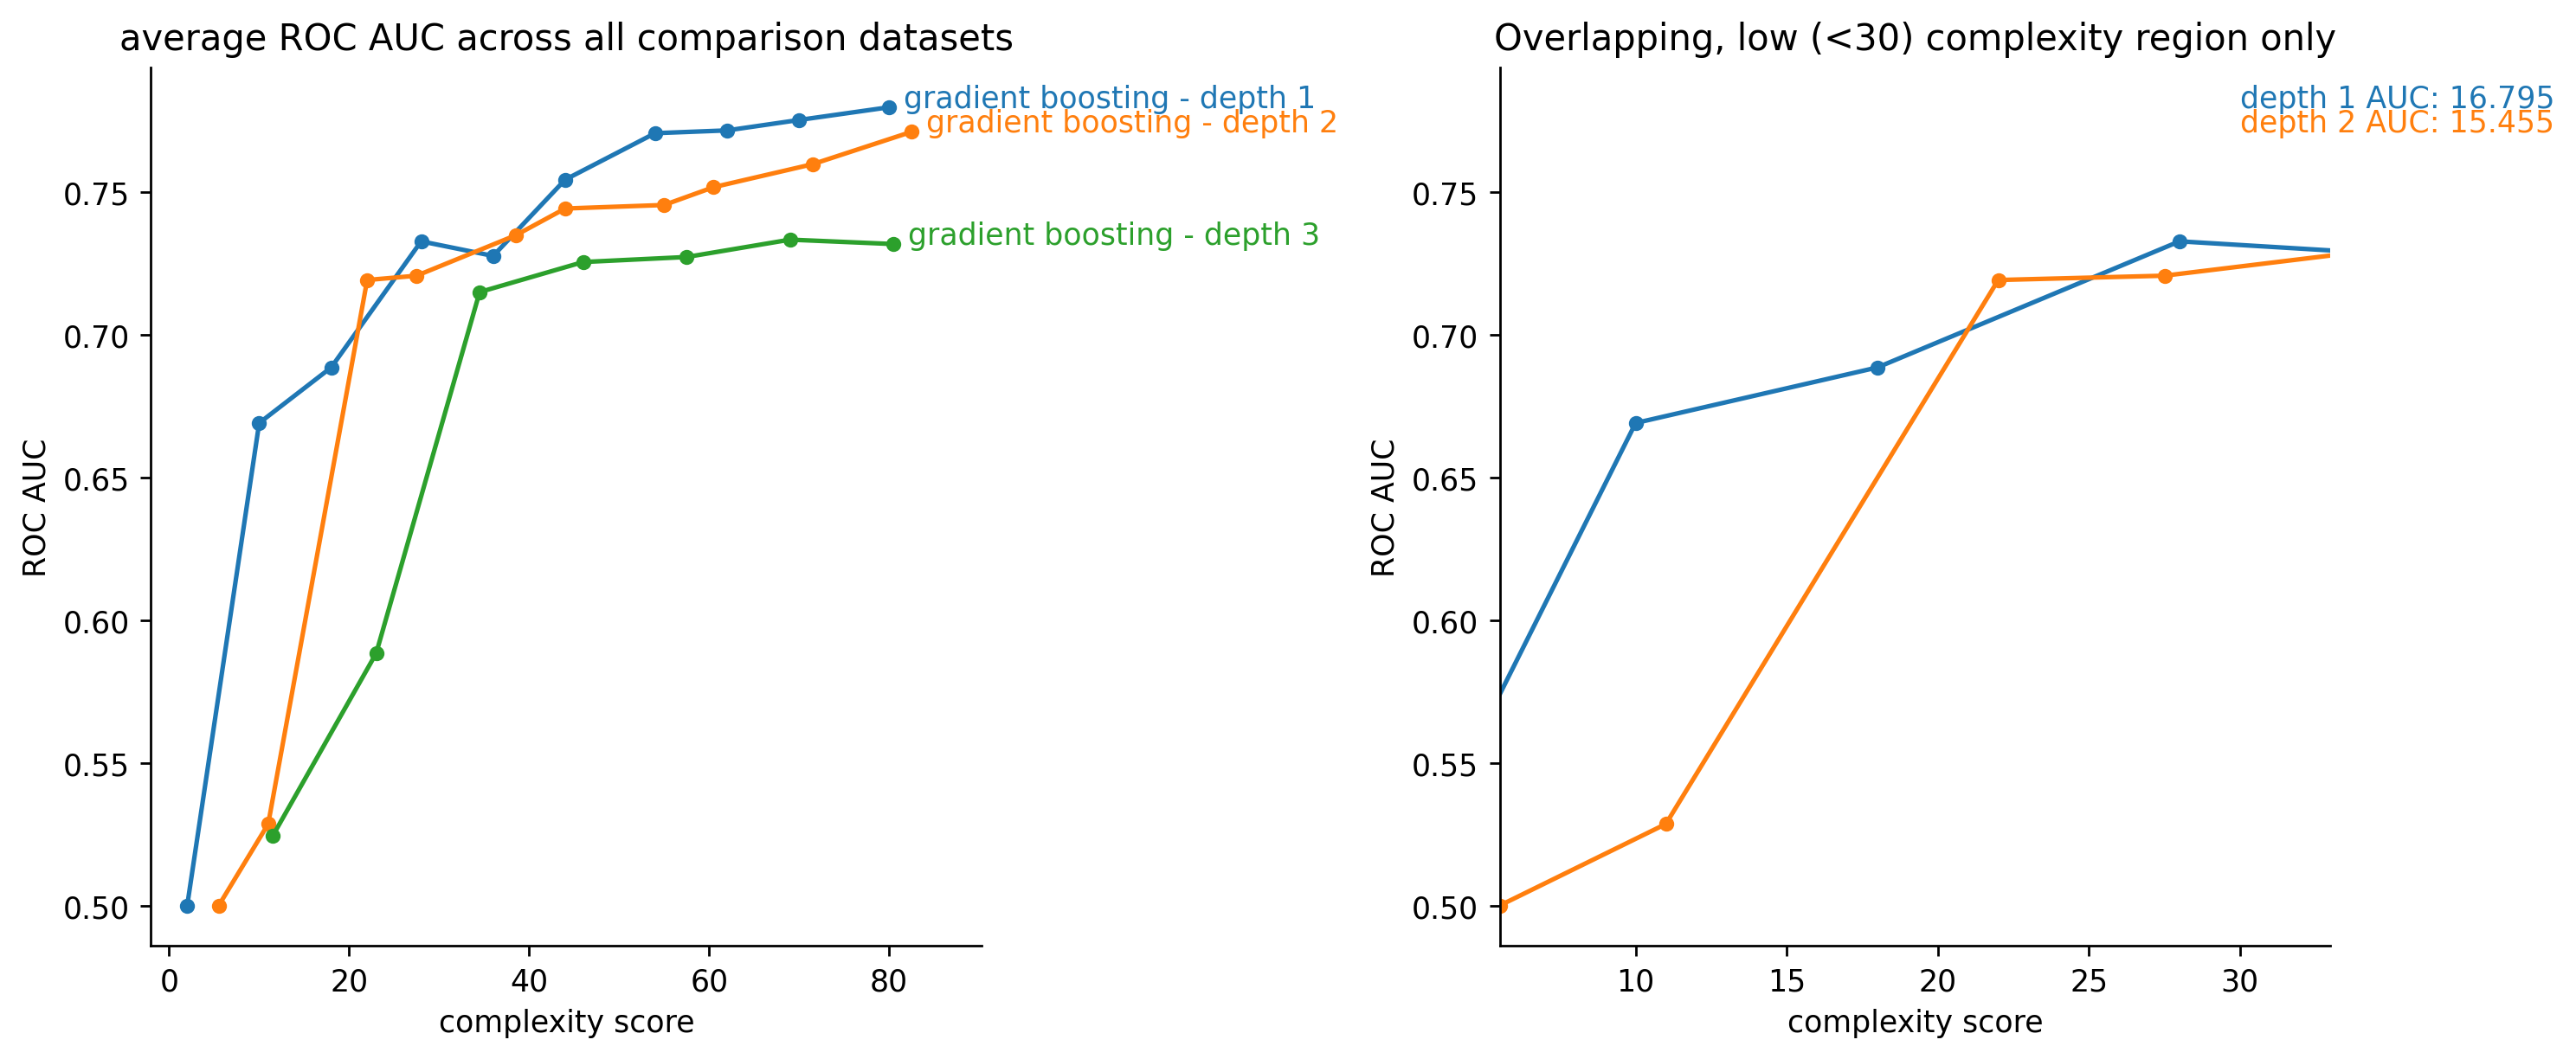

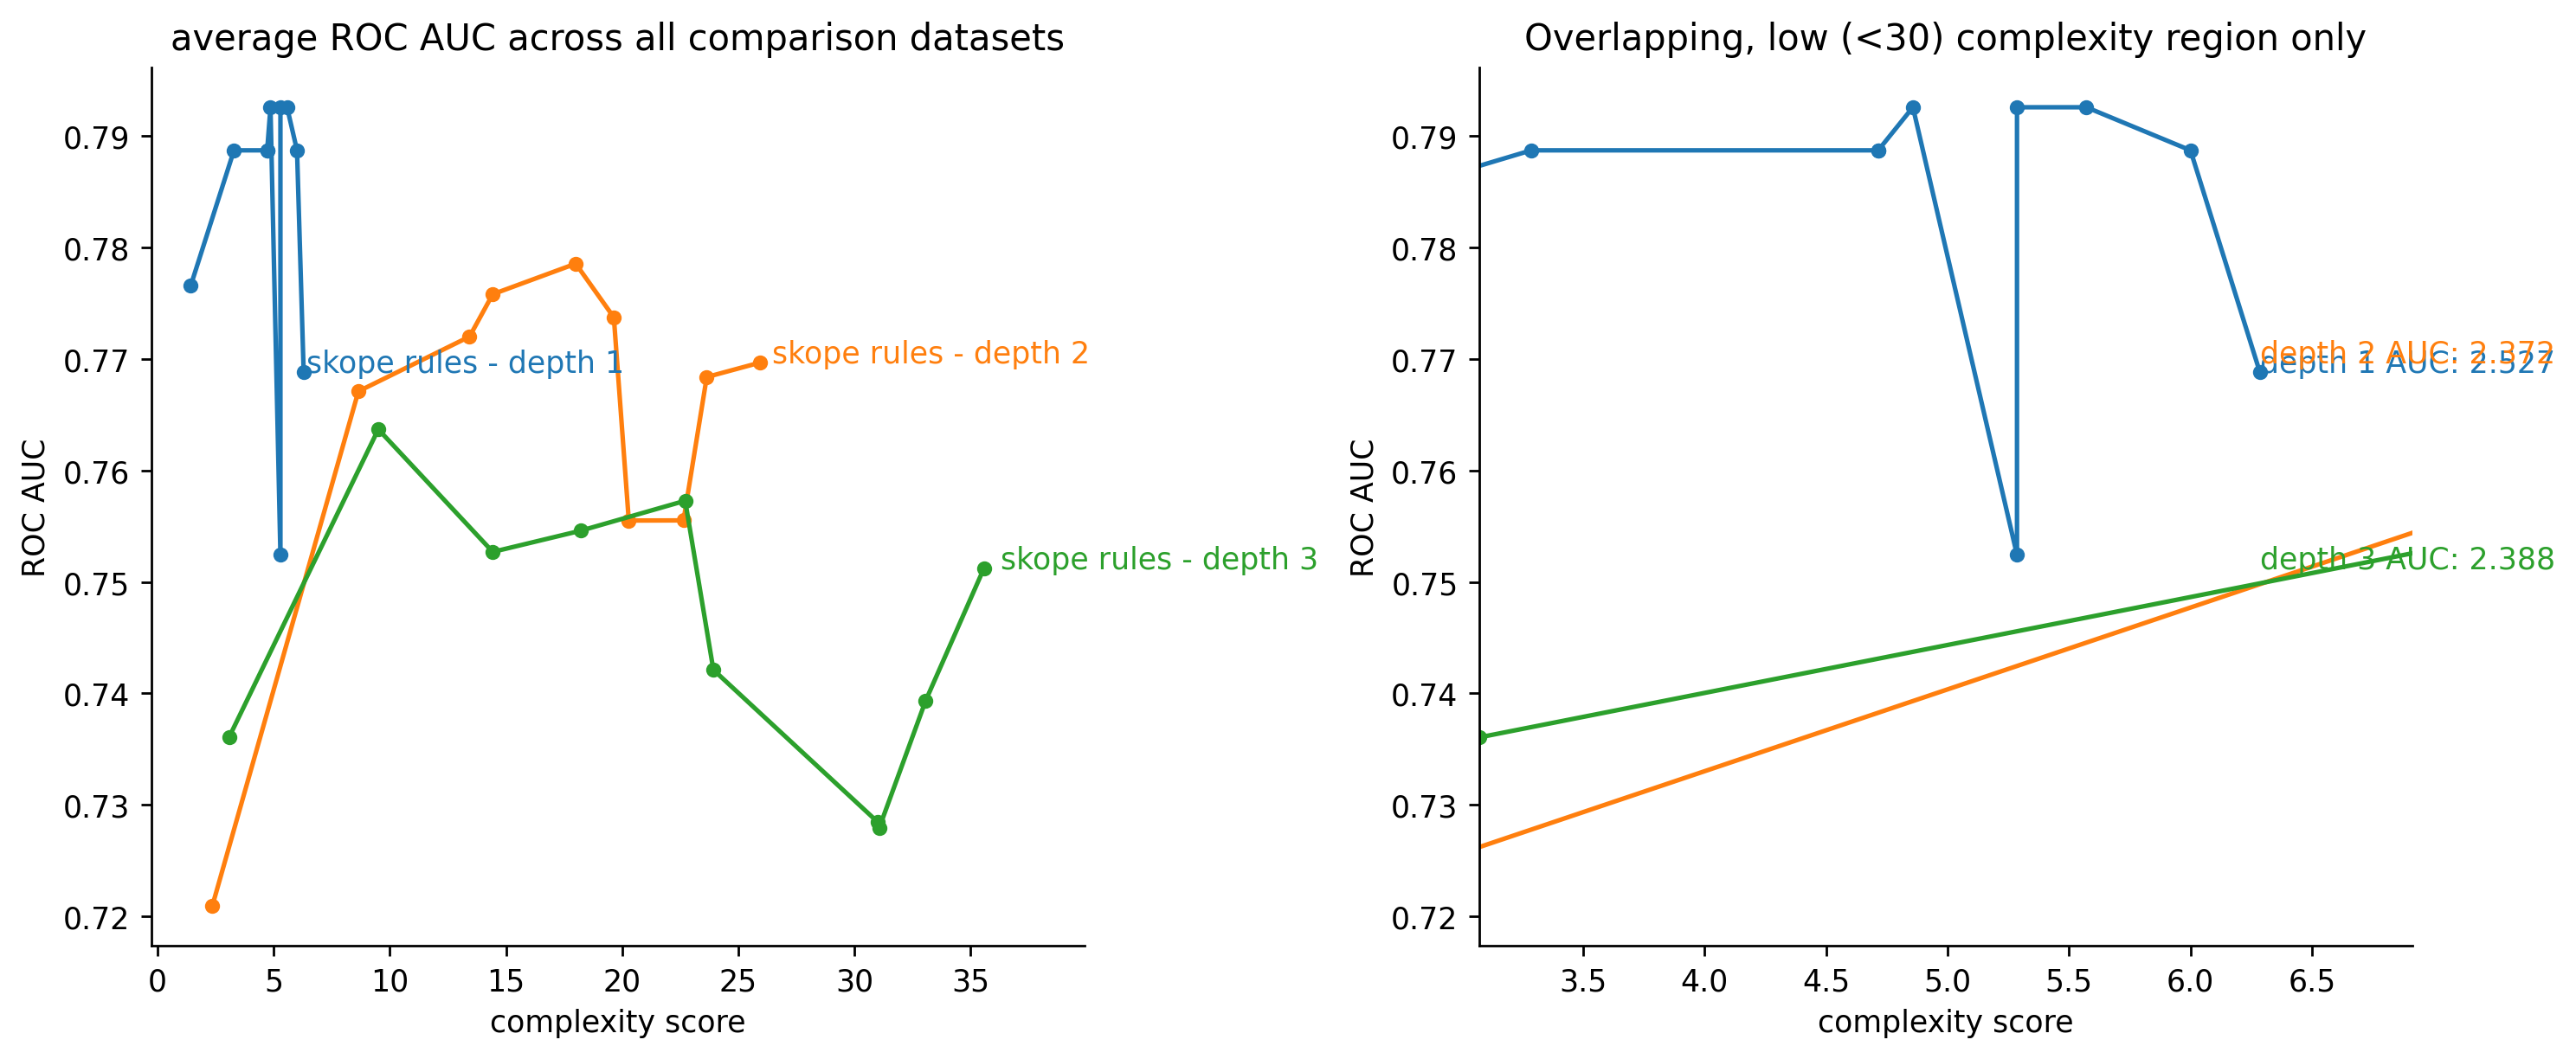

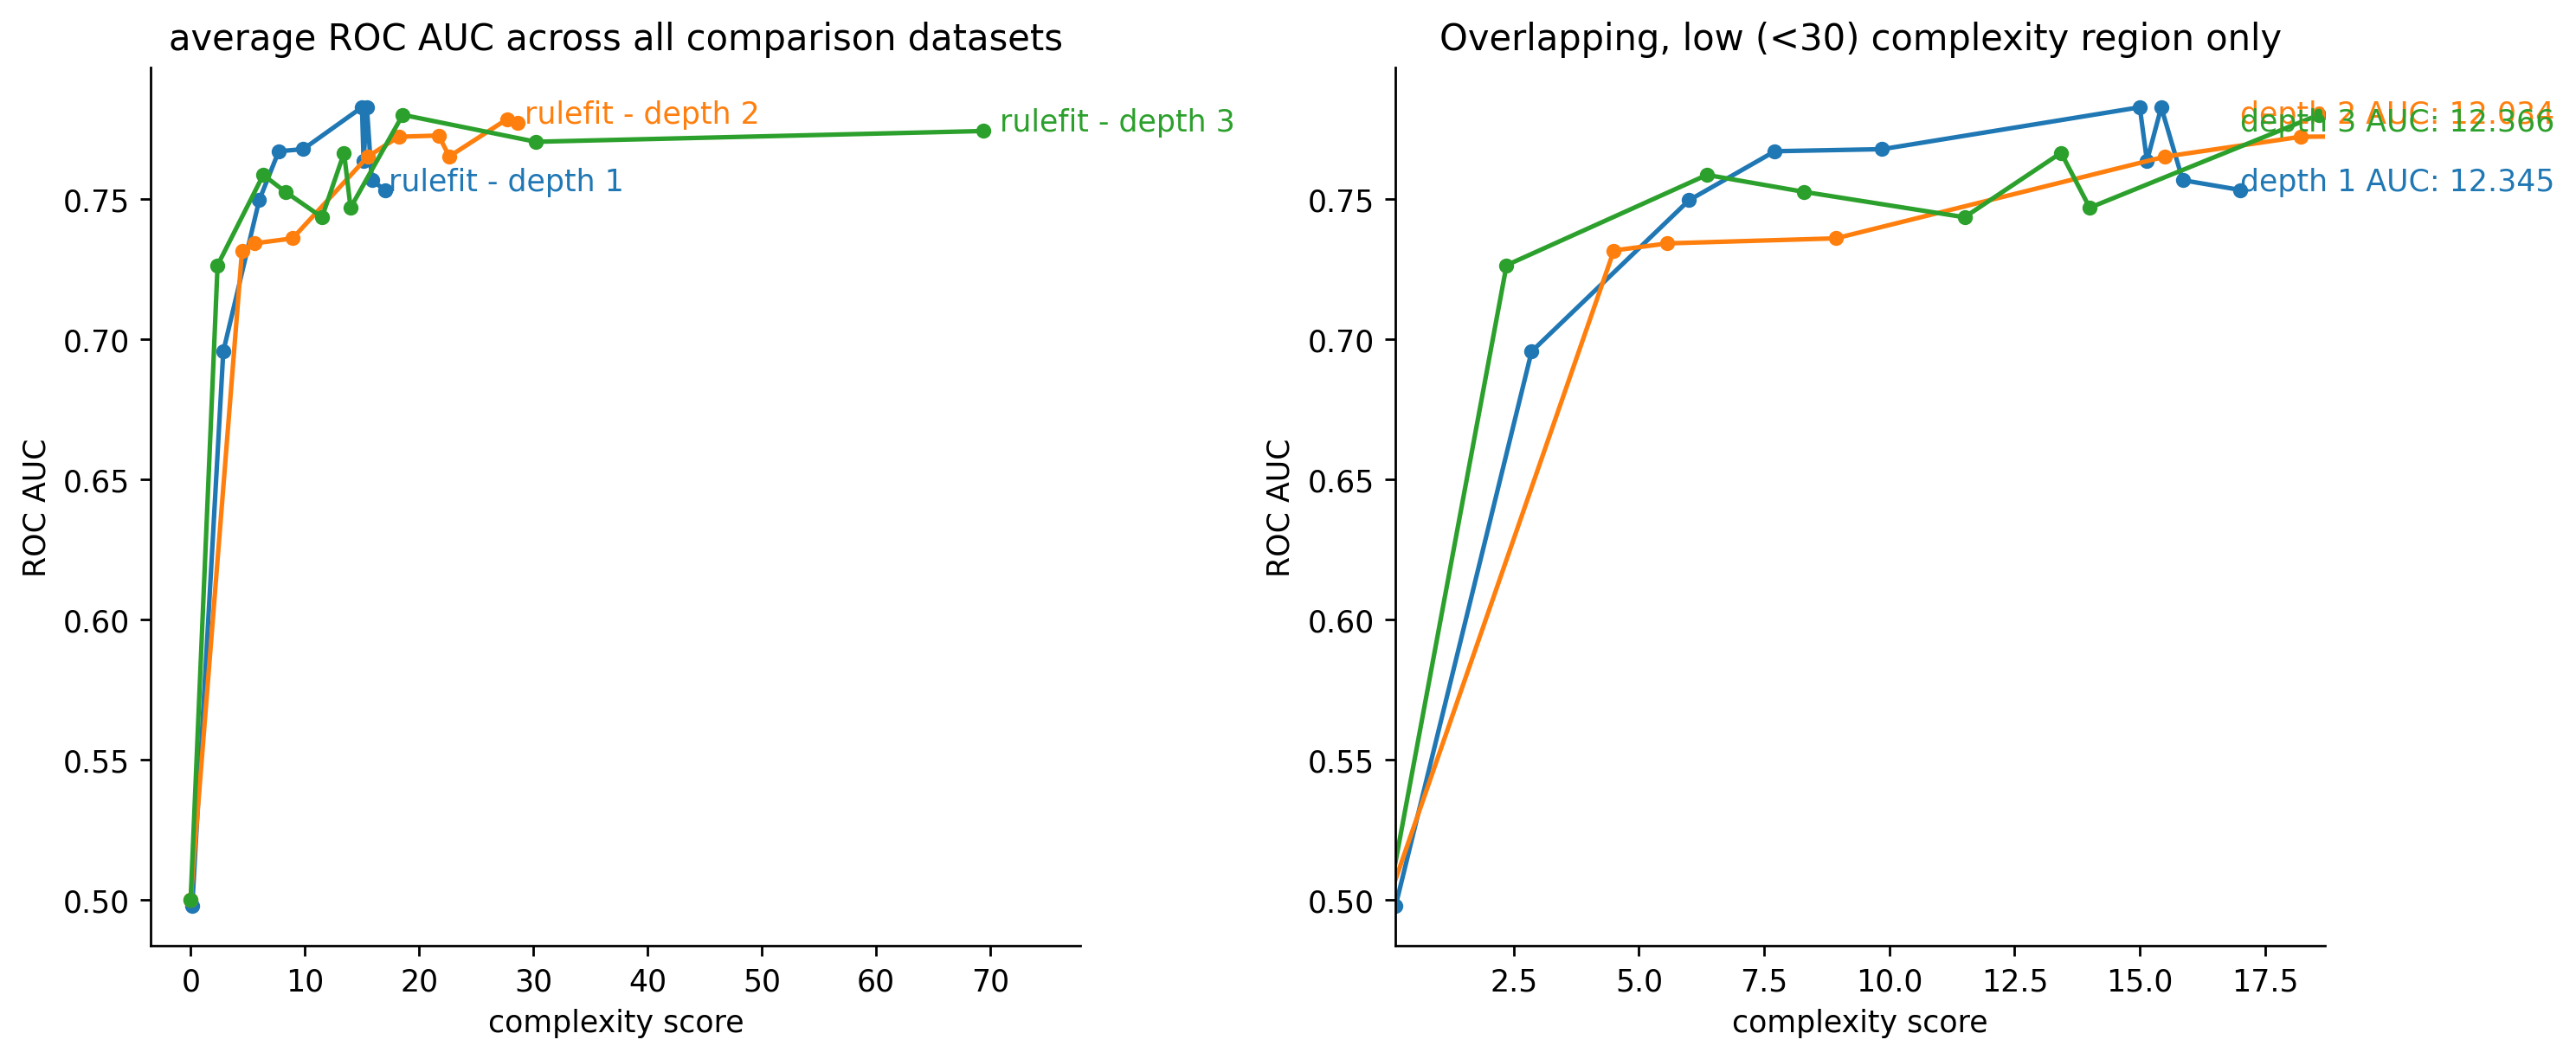

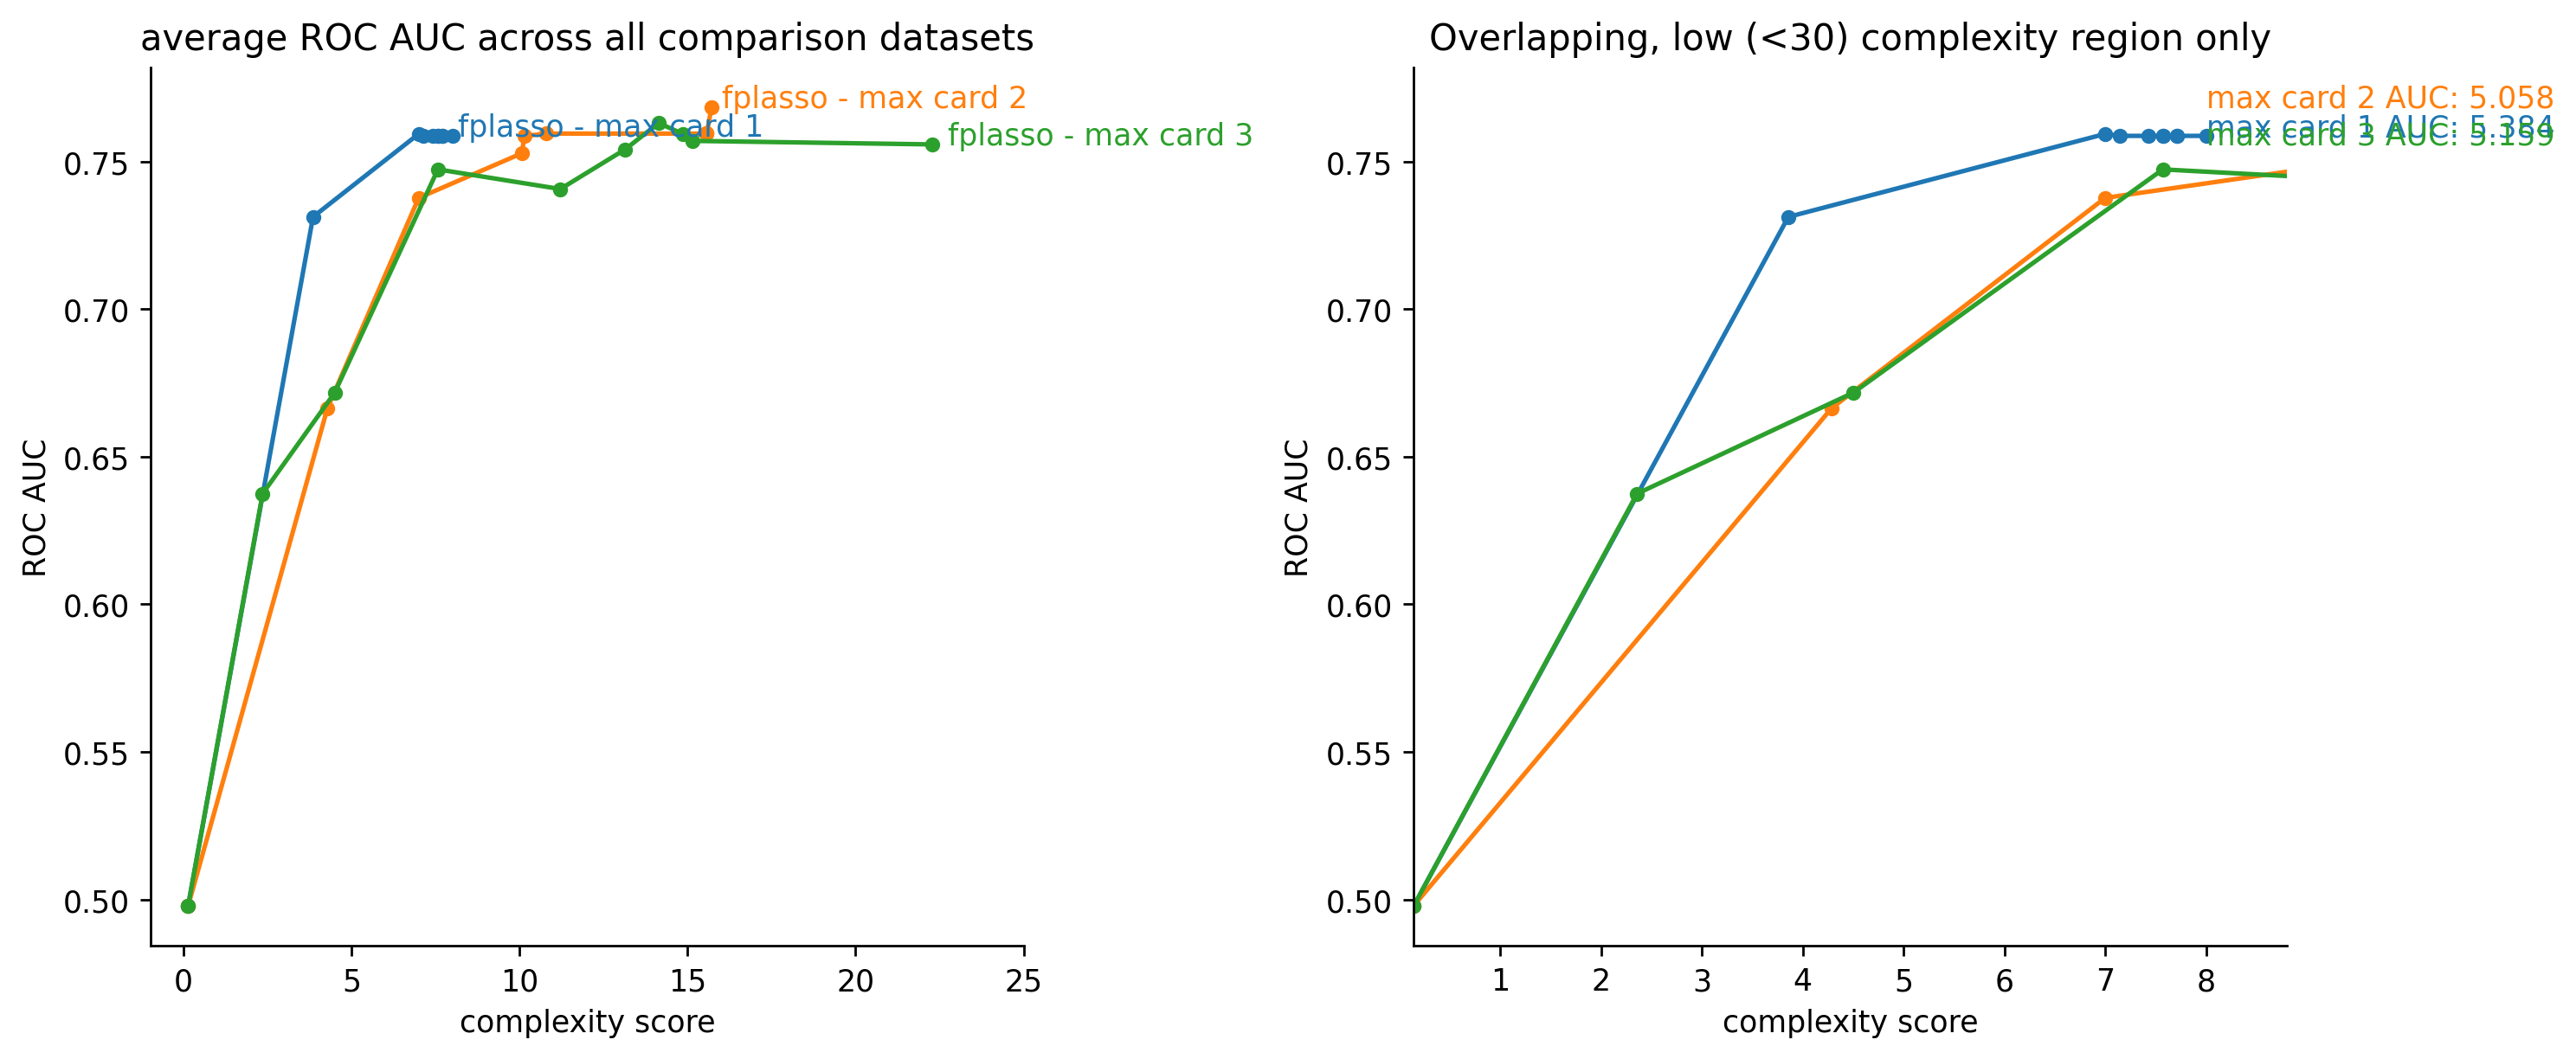

/Users/keyan/anaconda3/envs/imodels-3.9/lib/python3.9/site-packages/dvu/dvu.py:81: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/Users/keyan/bair/imodels/experiments/notebooks/viz.py:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


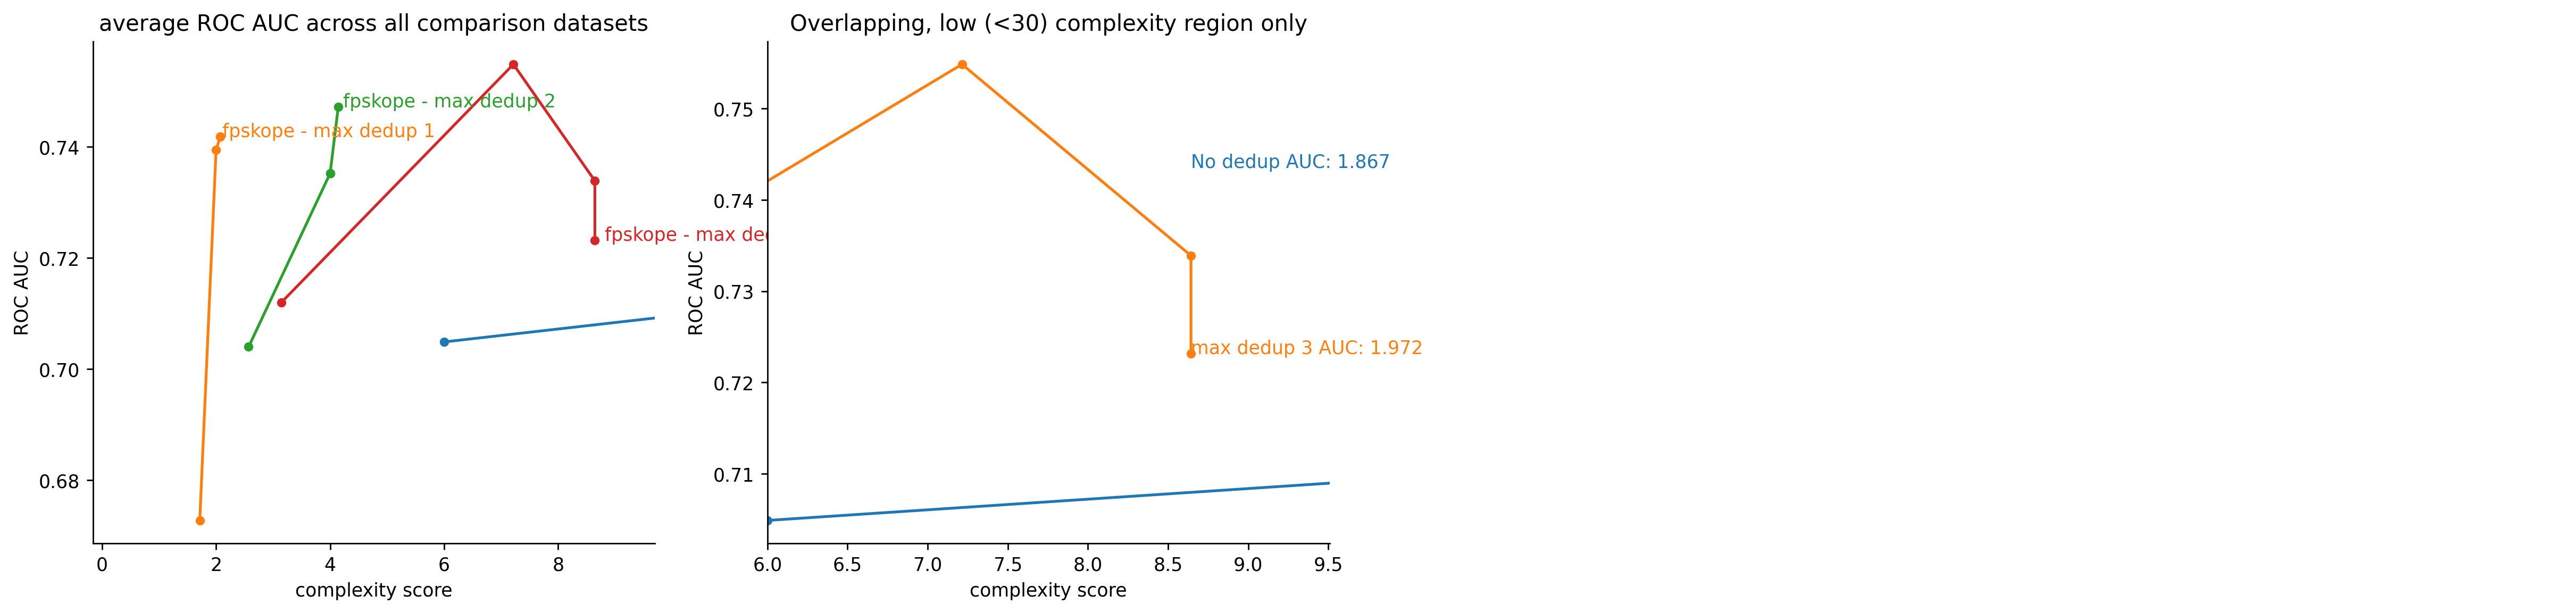

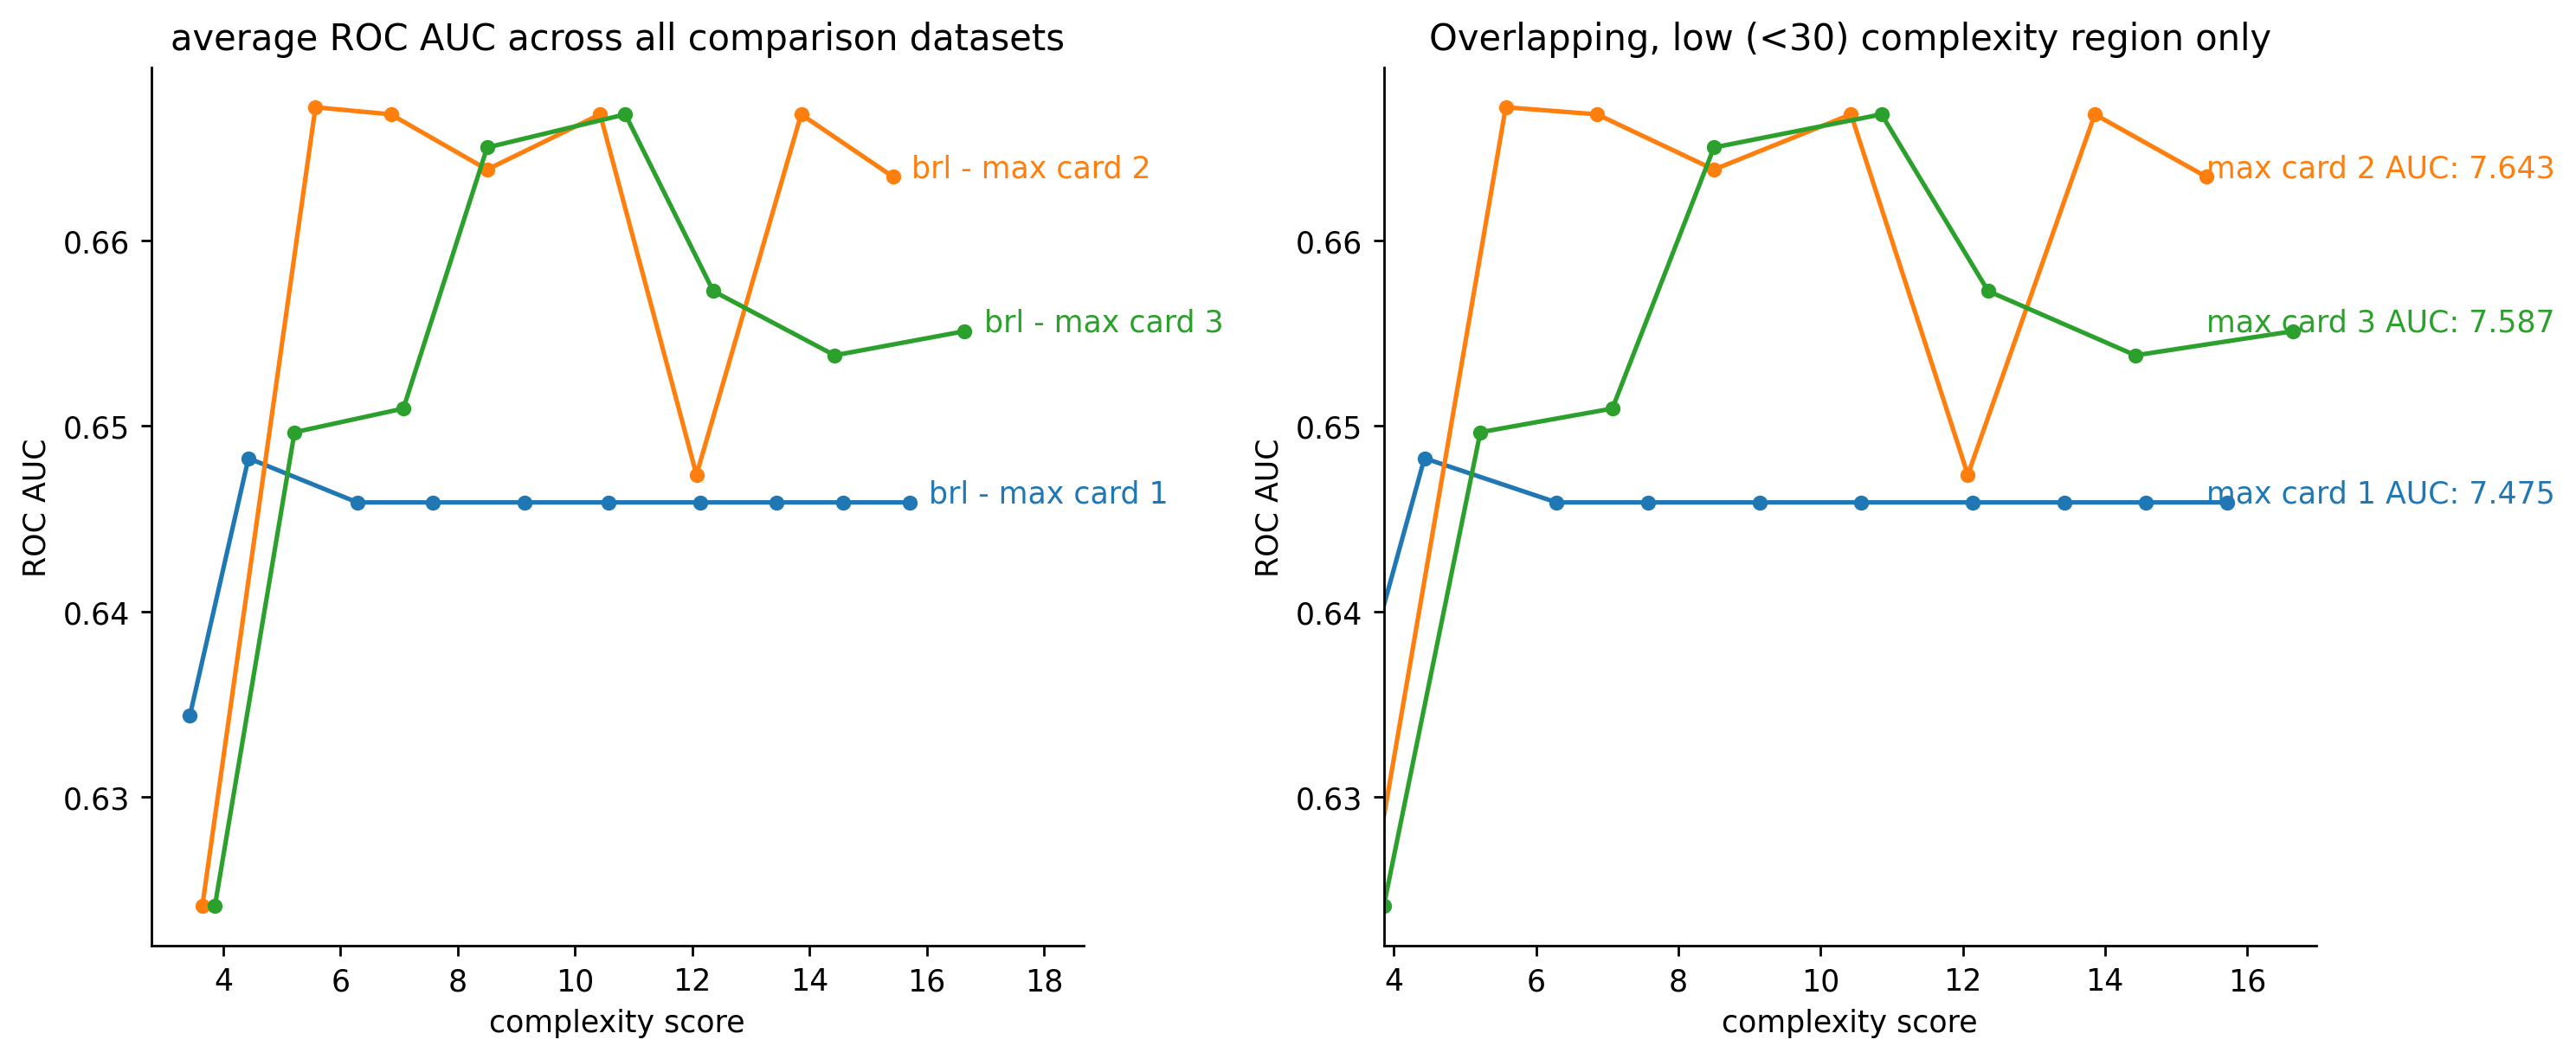

In [12]:
for model_name in ['random_forest', 'gradient_boosting', 'skope_rules', 
              'rulefit', 'fplasso', 'fpskope', 'brl']:
    comparison_result = get_comparison_result(MODEL_COMPARISON_PATH, model_name)
    viz.viz_comparison_val_average(comparison_result)
    plt.show()